In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Question 1

- Download daily stock prices for 3 stocks (e.g., Apple (AAPL), Google (GOOG), Facebook (FB)) for the last 10 years from AlphaVantage, Quandl, Yahoo, Google Finance or anywhere else

- Refs:
  - https://www.alphavantage.co/documentation/
  - https://blog.quandl.com/api-for-stock-data
  - https://www.quora.com/What-are-some-good-APIs-to-get-real-time-stock-quotes

- You can use close prices

In [2]:
API_KEY='A94WUGPZZ2RRCM8Z'

In [3]:
base_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&datatype=csv&outputsize=full'

In [4]:
aapl = pd.read_csv(base_url.format(symbol='AAPL', api_key=API_KEY))
aapl.head()

,timestamp,open,high,low,close,volume
0,2018-07-06,185.42,188.434,185.20,187.97,17485245
1,2018-07-05,185.26,186.410,184.28,185.40,16604248
2,2018-07-03,187.79,187.950,183.54,183.92,13954806
3,2018-07-02,183.82,187.300,183.42,187.18,17731343
4,2018-06-29,186.29,187.190,182.91,185.11,22737666


In [5]:
goog = pd.read_csv(base_url.format(symbol='GOOG', api_key=API_KEY))
goog.head()

,timestamp,open,high,low,close,volume
0,2018-07-06,1123.58,1140.93,1120.74,1140.17,996079
1,2018-07-05,1110.53,1127.50,1108.48,1124.27,1066685
2,2018-07-03,1135.82,1135.82,1100.02,1102.89,679034
3,2018-07-02,1099.00,1128.00,1093.80,1127.46,1217311
4,2018-06-29,1120.00,1128.23,1115.00,1115.65,1315121


In [6]:
fb = pd.read_csv(base_url.format(symbol='FB', api_key=API_KEY))
fb.head()

,timestamp,open,high,low,close,volume
0,2018-07-06,198.45,203.6400,197.700,203.23,19740131
1,2018-07-05,194.74,198.6500,194.030,198.45,19684193
2,2018-07-03,194.55,195.4000,192.520,192.73,13489514
3,2018-07-02,193.37,197.4500,192.220,197.36,13961578
4,2018-06-29,197.32,197.5997,193.955,194.32,15811602


In [7]:
aapl = aapl.loc[:3650]
goog = goog.loc[:3650]
fb = fb.loc[:3650]

## Question 2

- Compute returns r_i = (P_{i+1} - P_{i}) / P_{i}, where i is today, and i + 1 is tomorrow
- So r_i represents the return of an investment buying / selling today (day i) to
  selling / buying tomorrow (day i + 1).

- Can you compute some statistics on the return time series?
- For each stock
  - What is its distribution? Gaussian, Student-t with \nu degrees of freedom?
  - Is the distribution stationary over time?
    (Hint: look for stationarity tests)
  - Is there any auto-correlation in the time series?
  - Is there any interesting relationships between the returns of different stocks at the same time
    (contemporaneous) and not?
    (Suggestion: look at correlation, Granger causality, PCA decomposition of returns

In [8]:
for df in [aapl, goog, fb]:
    df['timestamp'] = df['timestamp'].apply(pd.to_datetime)
    df.set_index('timestamp')
    df['return'] = df\
        .rolling(window=2)\
        ['close']\
        .apply(lambda x: (x[1] - x[0]) / x[0])

In [9]:
df = aapl[['return']]\
  .join(goog[['return']], lsuffix='_aapl', rsuffix='_goog')\
  .join(fb[['return']].rename(columns={'return':'return_fb'}))\
  .set_index(aapl['timestamp'])\
  .iloc[1:]

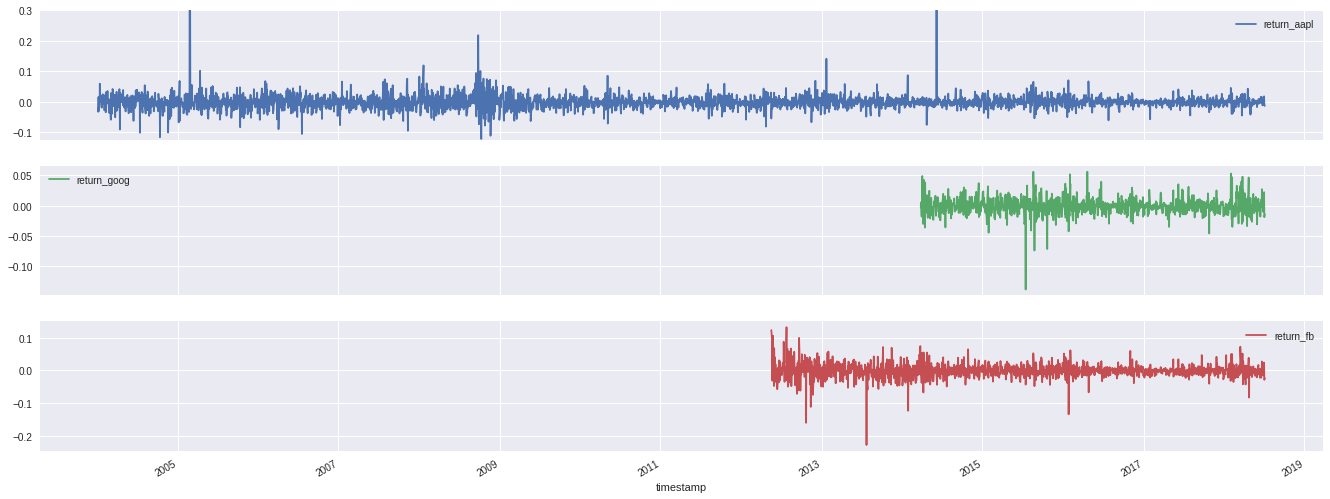

In [10]:
subplots = df.plot(subplots=True, figsize=(23,9))

subplots[0].set_ylim((-0.125, 0.3))
plt.show();

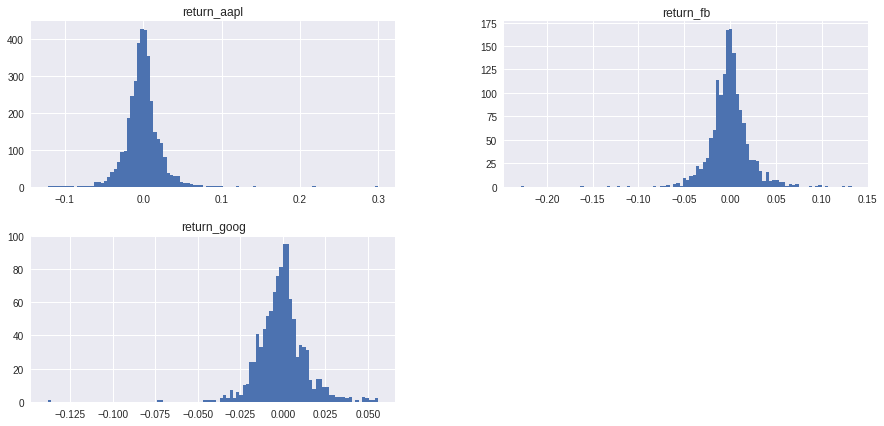

In [11]:
df['return_aapl'] = df['return_aapl'].apply(lambda x: x if x < 0.3 else 0.3)
# мы ограничиваем aapl сверху, чтобы посмотреть распределение, в расчетах, очевидно, будем использовать настоящие значения
df\
  .hist(bins=100, figsize=(15,7));

In [12]:
df = aapl[['return']]\
  .join(goog[['return']], lsuffix='_aapl', rsuffix='_goog')\
  .join(fb[['return']].rename(columns={'return':'return_fb'}))\
  .set_index(aapl['timestamp'])\
  .iloc[1:]

In [13]:
import scipy as sp

In [14]:
for col in df:
    # проверка на нормальное распределение
    k2, p = sp.stats.normaltest(df[col].dropna())
    print(col)
#     print('k2', k2)
    print('p', p)

return_aapl
('p', 0.0)
return_goog
('p', 3.8569814974350766e-58)
return_fb
('p', 2.5372037494337716e-87)


Исходя из того, что p достаточно малы, мы можем отвергнуть гипотезу о том, что распределение величин нормальное. Проверим каждую переменную на т-распределение.

In [15]:
def student_test(samples, prec, confidence=0.9):
    """
    Student's t-test.

    Parameters
    ----------
    samples : list
        List of numbers generated from your stochastic process.
    prec : scalar
        Desired distance between the empirical and real mean.
    confidence : scalar
        Desired probability of correct answer.

    Returns
    -------
    result : bool
        True if and only if your samples pass Student's t-test.
    """
    assert 0. < confidence < 1.
    n = len(samples)
    sigma = std(samples)
    quantile = sp.stats.t.ppf(confidence, n - 1)
    return quantile * sigma / sqrt(n) < prec

In [16]:
for col in df:
    test_result = student_test(df[col].dropna(), 0.005)
    print(col, test_result)

('return_aapl', True)
('return_goog', True)
('return_fb', True)


Видно, что величины имеют т-распределение.

In [24]:
import statsmodels.api as sm

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [38]:
acorrs = {'return_aapl': [], 'return_goog': [], 'return_fb': []}
for col in ['return_aapl', 'return_goog', 'return_fb']:
    statistic, pval = sm.stats.diagnostic.acorr_ljungbox(df[col].dropna(), lags=360)
    for i, pv in enumerate(pval):
        if pv < 0.05:
            acorrs[col].append(i)
    print col, len(acorrs[col])
    print

return_aapl 0

return_goog 346

return_fb 0



Из вывода видно, что google имеет автокорреляцию.

In [28]:
def acorrtest()
    statisctic, pvalue = sm.stats.diagnostic.acorr_ljungbox(df['return_aapl'], lags=360)
    for i, pval in enumerate(pvalue):
        if pval < 0.05:
            print i

In [21]:
import seaborn as sns

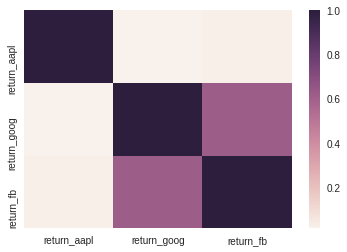

In [23]:
sns.heatmap(df.dropna().corr());

Из графика корреляции видно, что есть незначительная кореляция между стоимостью google и facebook, а apple не связан с двумя другими.

In [46]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [48]:
x = StandardScaler().fit_transform(df.dropna())

In [51]:
pca = decomposition.PCA(n_components=2)
pdf = pd.DataFrame(pca.fit_transform(x), columns=['x', 'y'])

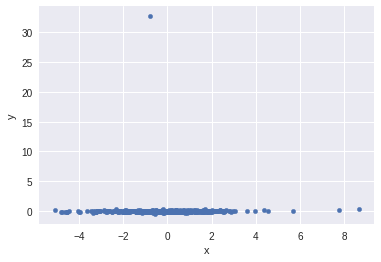

In [53]:
pdf.plot(kind='scatter', x='x', y='y');

Видно, что есть область близких значений.

In [43]:
for col in df:
    autocorr = estimated_autocorrelation(df[col].dropna())
    print(col, autocorr)

return_aapl [ 9.99726027e-01 -3.31113652e-05 -1.00693263e-03 ... -1.00057593e-02
  3.37865675e-02  3.25021321e-02]
return_goog [ 0.99907149  0.05730565 -0.01832399 ...  0.12110594 -0.09967277
  0.14471294]
return_fb [ 9.99351492e-01  2.14379108e-02 -3.58868483e-03 ...  6.72278018e-01
 -5.65385551e+00 -5.57943048e+00]


In [139]:
df.describe()

,return_aapl,return_goog,return_fb
count,3650.000000,1077.000000,1542.000000
mean,0.000801,-0.000561,-0.000827
std,0.101057,0.014169,0.022485
min,-0.122075,-0.138320,-0.228441
25%,-0.011733,-0.008169,-0.011749
50%,-0.000997,-0.000628,-0.001052
75%,0.008589,0.005818,0.009091
max,5.889755,0.056165,0.132462


Из графиков видно, что return - величина нестационарная, но проверим это с помощью statsmodels.

In [22]:
test_statistic, pvalue, usedlag, nobs, critical_values, icbest = sm.tsa.stattools.adfuller(df['return_aapl'])

print(
    'test_statistic', test_statistic, '\n',
    'pvalue', pvalue, '\n',
    'usedflag', usedlag, '\n',
    'observations', nobs, '\n',
    'critical_values', critical_values, '\n',
    'icbest', icbest
)

test_statistic -60.392139859947726 
 pvalue 0.0 
 usedflag 0 
 observations 3649 
 critical_values {'1%': -3.4321433423211882, '5%': -2.862332398828442, '10%': -2.567191805919415} 
 icbest -6286.108288636919


In [25]:
test_statistic, pvalue, usedlag, nobs, critical_values, icbest = sm.tsa.stattools.adfuller(df['return_goog'].dropna())

print(
    'test_statistic', test_statistic, '\n',
    'pvalue', pvalue, '\n',
    'usedflag', usedlag, '\n',
    'observations', nobs, '\n',
    'critical_values', critical_values, '\n',
    'icbest', icbest
)

test_statistic -30.95729200165903 
 pvalue 0.0 
 usedflag 0 
 observations 1076 
 critical_values {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934} 
 icbest -5975.610304305363


In [26]:
test_statistic, pvalue, usedlag, nobs, critical_values, icbest = sm.tsa.stattools.adfuller(df['return_aapl'].dropna())

print(
    'test_statistic', test_statistic, '\n',
    'pvalue', pvalue, '\n',
    'usedflag', usedlag, '\n',
    'observations', nobs, '\n',
    'critical_values', critical_values, '\n',
    'icbest', icbest
)

test_statistic -60.392139859947726 
 pvalue 0.0 
 usedflag 0 
 observations 3649 
 critical_values {'1%': -3.4321433423211882, '5%': -2.862332398828442, '10%': -2.567191805919415} 
 icbest -6286.108288636919


## Question 3

- Assume you have an equity strategy that every day makes a prediction f_i on the value of r_i

- The profit-and-loss (pnl) for each day is

   pnl_i = f_i * r_i

- Assume that f_i is standard Gaussian with mean = 0 and std dev = 1

- Generate a few random realizations of f_i: plot pnl_i and pnl = cumsum(pnl_i)


In [121]:
# pnl_df = pd.DataFrame()
for col in ['return_aapl', 'return_goog', 'return_fb']:
    df[col.strip('return_') + '_f'] = np.random.randn(df.shape[0])
    df[col.strip('return_') + '_pnl'] = df[col] * df[col.strip('return_') + '_f']
    df[col.strip('return_') + '_pnl_csum'] = df[col.strip('return_') + '_pnl'].cumsum()

df.head()

,return_aapl,return_goog,return_fb,aapl_f,aapl_pnl,aapl_pnl_csum,goog_f,goog_pnl,goog_pnl_csum,fb_f,fb_pnl,fb_pnl_csum,aaplSR,googSR,fbSR
timestamp,,,,,,,,,,,,,,,
2018-07-05,-0.013672,-0.013945,-0.023520,-0.497666,0.006804,0.006804,-2.669445,0.037226,0.037226,-1.969209,0.046316,0.046316,0.003390,0.027239,0.006646
2018-07-03,-0.007983,-0.019017,-0.028823,0.565148,-0.004511,0.002293,0.279702,-0.005319,0.031907,1.829772,-0.052740,-0.006424,-0.000662,0.082231,-0.009772
2018-07-02,0.017725,0.022278,0.024023,-1.026776,-0.018200,-0.015907,-0.638110,-0.014216,0.017691,-0.957727,-0.023008,-0.029432,0.006595,0.101422,-0.019194
2018-06-29,-0.011059,-0.010475,-0.015403,-0.258624,0.002860,-0.013047,-0.373977,0.003917,0.021609,-0.574093,0.008843,-0.020589,0.017892,0.108522,0.025836
2018-06-28,0.002107,-0.001282,0.009829,0.479760,0.001011,-0.012036,0.180858,-0.000232,0.021377,-1.539794,-0.015135,-0.035724,0.013067,0.108116,0.032607


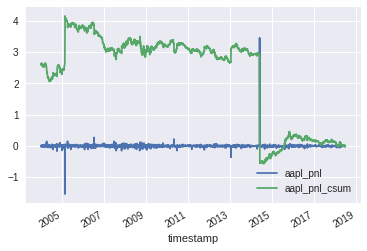

In [122]:
df[['aapl_pnl', 'aapl_pnl_csum']]\
    .plot();

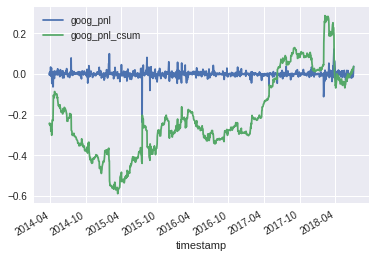

In [123]:
df[['goog_pnl', 'goog_pnl_csum']]\
    .plot();

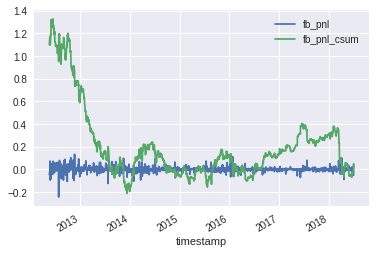

In [124]:
df[['fb_pnl', 'fb_pnl_csum']]\
    .plot();

## Question 4

- For a pnl timeseries Sharpe Ratio is defined as SR = E[pnl_i] / \sqrt{V[pnl_i]}

- Assume that f_i has a given hit rate = 1/n \sum_i I(sign(f_i) == sign(r_i))
  - Hit rate is a measure of accuracy: how often we guess the direction of the stock movement correctly
- Remember that f_i is a random variable so you can draw different realizations of it
- What is the distribution of the SR(pnl_i) given f_i?
- Ideally you want to generate a plot varying hit_rate from 0 to 1.0 on the x-axis and computing
  the corresponding distribution of SR on the y-axis
- Note that pnl_i is a random var since it is a function of the random variable f_i

- You can plot the distribution as a box plot or using just mean and std err

In [125]:
hit_rates = {}
sharp_ratios = {}
for col in ['return_aapl', 'return_goog', 'return_fb']:
    r = df[col].dropna()
    f = df[col.strip('return_') + '_f'].iloc[:len(r)]
    
    # use this block for hit rate
    hr = pd.Series(np.sign(r) == np.sign(f)).apply(lambda x: 1 if x else 0)
    hit_rates[col] = 1 / len(r) * hr.cumsum()
    
    # uncomment these for different metrics
    # RMSE
    # rmse = pd.Series(np.sqrt(np.mean(f - r)))
    # MAD
    # mad = pd.Series(np.abs(f - r) / len(r))
    SRs = []
    
    for i, (ri, fi) in enumerate(zip(r, f)):
        SR = r[:i].mean() / np.sqrt(np.std(f[:i]))
        SRs.append(SR)
    
    SR = pd.Series(SRs, name=col.strip('return_'))
    sharp_ratios[col.strip('return_')] = SRs

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


Ок, вот тут я не до конца понимаю, что такое на самом деле этот коэффициент Шарпа, но предположим, что это такая бегущая средняя величина по профит-энд-лоссу. Продолжим.

In [126]:
for col in sharp_ratios:
    sharp_ratios[col] = pd.Series(sharp_ratios[col], name=col)

In [127]:
# triple zip_longest

SR = pd.concat(sharp_ratios, axis=1)[2:]

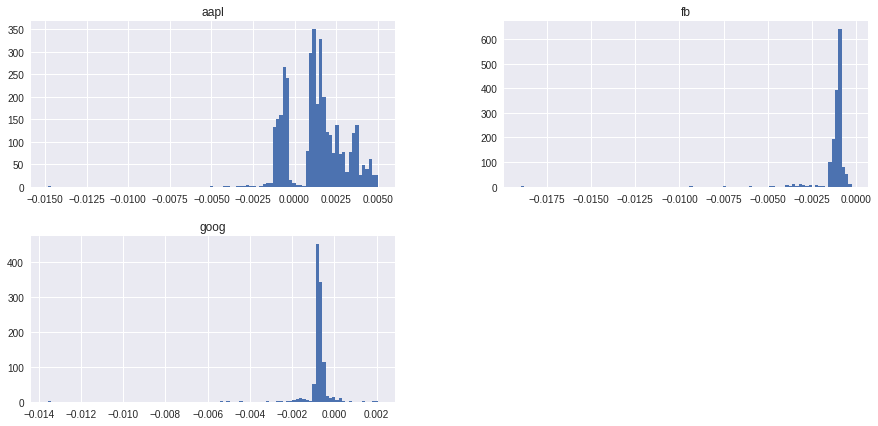

In [128]:
SR.hist(bins=100, figsize=(15,7));

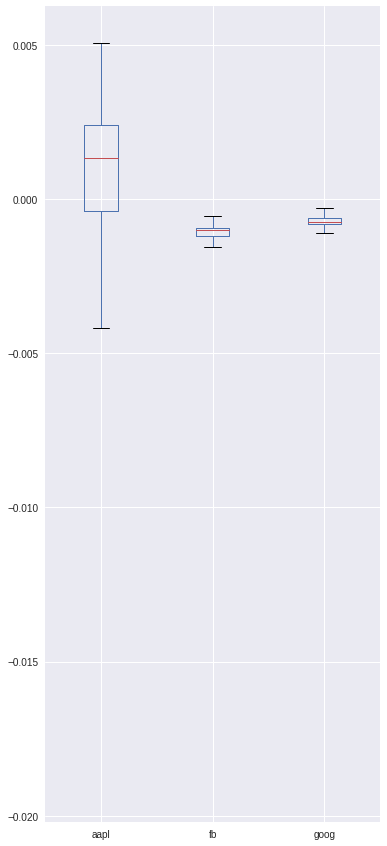

In [131]:
SR.boxplot(figsize=(6,15));

## Question 5

- What if instead of hit rate, you use root mean square error (RMSE) between f_i and r_i?
- How does the distribution of SR changes?
- What if you use mean absolute (MAD) of f_i and r_i?

- Make the code flexible to changing input measures (hit rate, RMSE, MAD) and output measures

If f_i was our actual strategy, we'd have several options:

*   hit rate shows only percentage of good decisions, and we can still lose money, if, say, we'd buy a big amount, and sell small - we'd be in debt
*   RMSE shows what part of potential income we missed - that's way better.

